# Depth prediction

## Layer functions to simplify build

In [1]:
from tensorflow.contrib.layers import flatten
from tensorflow.contrib.layers import xavier_initializer as init
import tensorflow as tf

tf.logging.set_verbosity(tf.logging.ERROR)


def conv_layer(input, shape, strides=(1, 1, 1, 1), name="conv"):
    with tf.variable_scope(name):
        w = tf.get_variable("w", shape=shape, initializer=init())
        b = tf.get_variable("b", shape=[shape[-1]], initializer=init())
        return tf.nn.relu(tf.nn.conv2d(input, w, strides, 'VALID') + b)

    
def conv_layer_no_act(input, shape, strides=(1, 1, 1, 1), name="conv"):
    with tf.variable_scope(name):
        w = tf.get_variable("w", shape=shape, initializer=init())
        b = tf.get_variable("b", shape=[shape[-1]], initializer=init())
        return tf.nn.conv2d(input, w, strides, 'VALID') + b
    
    
def fc_layer(input, shape, name="fc"):
    with tf.variable_scope(name):
        w = tf.get_variable("w", shape=shape, initializer=init())
        b = tf.get_variable("b", shape=[shape[-1]], initializer=init())
        return tf.nn.relu(tf.add(tf.matmul(input, w), b))
    
def fc_layer_no_act(input, shape, name="fc"):
    with tf.variable_scope(name):
        w = tf.get_variable("w", shape=shape, initializer=init())
        b = tf.get_variable("b", shape=[shape[-1]], initializer=init())
        return tf.add(tf.matmul(input, w), b)


def pool(input):
    return tf.nn.max_pool_with_argmax(input, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')


def unravel_argmax(argmax, shape):
    output_list = []
    output_list.append(argmax // (shape[2] * shape[3]))
    output_list.append(argmax % (shape[2] * shape[3]) // shape[3])
    return tf.pack(output_list)


def unpool_layer2x2(x, raveled_argmax, out_shape):
    argmax = self.unravel_argmax(raveled_argmax, tf.to_int64(out_shape))
    output = tf.zeros([out_shape[1], out_shape[2], out_shape[3]])

    height = tf.shape(output)[0]
    width = tf.shape(output)[1]
    channels = tf.shape(output)[2]

    t1 = tf.to_int64(tf.range(channels))
    t1 = tf.tile(t1, [((width + 1) // 2) * ((height + 1) // 2)])
    t1 = tf.reshape(t1, [-1, channels])
    t1 = tf.transpose(t1, perm=[1, 0])
    t1 = tf.reshape(t1, [channels, (height + 1) // 2, (width + 1) // 2, 1])

    t2 = tf.squeeze(argmax)
    t2 = tf.pack((t2[0], t2[1]), axis=0)
    t2 = tf.transpose(t2, perm=[3, 1, 2, 0])

    t = tf.concat(3, [t2, t1])
    indices = tf.reshape(t, [((height + 1) // 2) * ((width + 1) // 2) * channels, 3])

    x1 = tf.squeeze(x)
    x1 = tf.reshape(x1, [-1, channels])
    x1 = tf.transpose(x1, perm=[1, 0])
    values = tf.reshape(x1, [-1])

    delta = tf.SparseTensor(indices, values, tf.to_int64(tf.shape(output)))
    return tf.expand_dims(tf.sparse_tensor_to_dense(tf.sparse_reorder(delta)), 0)

## Network structure

[Source article](https://papers.nips.cc/paper/5539-depth-map-prediction-from-a-single-image-using-a-multi-scale-deep-network.pdf)

![](img/structure.png)

In [2]:
input_shape = (None, 240, 320, 3)
x = tf.placeholder(tf.float32, input_shape)
y = tf.placeholder(tf.float32, None)
keep_prob = tf.placeholder(tf.float32)

normalized = tf.div(tf.subtract(x, 128), 255)

fine1, argmax_fine1 = pool(conv_layer(normalized, [9, 9, 3, 63], strides=[1, 2, 2, 1], name="fine1"))
fine_shape = fine1.get_shape().as_list()

coarse1, argmax_coarse1 = pool(conv_layer(normalized, [11, 11, 3, 96], strides=[1, 4, 4, 1], name="coarse1"))
print(coarse1.get_shape())
coarse2, argmax_coarse2 = pool(conv_layer(coarse1, [5, 5, 96, 256], name="coarse2"))
print(coarse2.get_shape())
coarse3 = conv_layer(coarse2, [3, 3, 256, 384], name="coarse3")
print(coarse3.get_shape())
coarse4 = conv_layer(coarse3, [3, 3, 384, 384], name="coarse4")
print(coarse4.get_shape())
coarse5 = conv_layer(coarse4, [3, 3, 384, 256], name="coarse5")
print(coarse5.get_shape())
coarse6 = tf.nn.dropout(conv_layer(coarse5, [6, 11, 256, 4096], name="coarse6"), keep_prob)
print(coarse6.get_shape())
coarse7 = conv_layer(coarse6, [1, 1, 4096, 4096], name="coarse7")
print(coarse7.get_shape())

#reshaped = tf.reshape(coarse7, [-1, fine_shape[1], fine_shape[2], 1], name="reshaped")

#fine2 = conv_layer(tf.concat([fine1, reshaped], 3), [5, 5, 64, 64], name="fine2")
#fine3 = conv_layer_no_act(fine2, [5, 5, 64, 1], name="fine3")

(?, 29, 39, 96)
(?, 12, 17, 256)
(?, 10, 15, 384)
(?, 8, 13, 384)
(?, 6, 11, 256)
(?, 1, 1, 4096)
(?, 1, 1, 4096)


## Read images from preprocessed file

See [read_mat.py](read_mat.py)

In [3]:
from sklearn.utils import shuffle
import numpy as np

images_file = "samples/images-0.np"
depths_file = "samples/depths-0.np"
length_file = "samples/length-0.np"
with open(length_file, "rb") as f:
    length = np.fromfile(f, dtype=np.int32)[0]

images = np.memmap(images_file, mode="r", dtype=np.uint8, shape=(length, 480, 640, 3))
depths = np.memmap(depths_file, mode="r", dtype=np.int32, shape=(length, 480, 640))

(3733, 480, 640, 3)


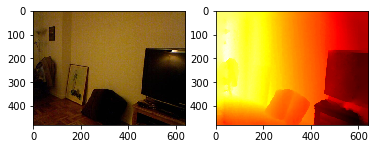

In [4]:
from random import randint
from matplotlib import pyplot as plt

%matplotlib inline

print(images.shape)

fig = plt.figure()
sp = fig.add_subplot(1, 2, 1)
sp.imshow(images[1705])
sp = fig.add_subplot(1, 2, 2)
sp.imshow(depths[1705], cmap='hot')

## Create generator to prevent loading images in RAM

In [5]:
import cv2

def batch_generator(images, depths, batch_size=128, output_shape=(320, 240)):
    image_shape = (input_shape[2], input_shape[1])
    
    while(1):
        indices = np.random.permutation(images.shape[0])
        for offset in range(0, len(indices), batch_size):
            index_slice = indices[offset: offset + batch_size]
            X = np.empty((index_slice.shape[0], image_shape[1], image_shape[0], 3), dtype=np.uint8)
            y = np.empty((index_slice.shape[0], output_shape[1], output_shape[0], 1))
            
            for i in range(0, index_slice.shape[0]):
                image = images[index_slice[i]]
                depth = (depths[index_slice[i]]).astype(np.float32)
                X[i, :, :, :] = cv2.cvtColor(cv2.resize(image, image_shape), cv2.COLOR_BGR2YUV)
                y[i, :, :, 0] = cv2.resize(depth, output_shape)
                
            yield X, y

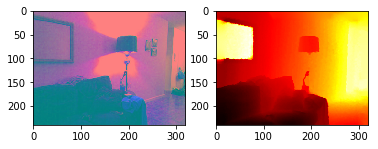

In [6]:
gen = batch_generator(images, depths)
batch_x, batch_y = next(gen)
fig = plt.figure()
sp = fig.add_subplot(1, 2, 1)
sp.imshow(batch_x[0])
sp = fig.add_subplot(1, 2, 2)
sp.imshow(batch_y[0, :, :, 0], cmap='hot')

## Setup loss operation and training parameters

In [7]:
rate = 0.001

EPOCHS = 100
BATCH_SIZE = 128

λ = tf.constant(0, dtype=tf.float32)

def get_loss_operation(output):
    size = tf.cast(tf.size(y), tf.float32)
    d = output - tf.log(y)
    return tf.reduce_sum(tf.square(d)) / size - (λ / tf.square(size)) * tf.square(tf.reduce_sum(d))

optimizer = tf.train.AdamOptimizer(learning_rate=rate)

In [8]:
saver = tf.train.Saver()

def evaluate(X_data, y_data, loss_operation, output_shape):
    num_examples = len(X_data)
    total_loss = 0
    sess = tf.get_default_session()
    
    gen = batch_generator(X_data, y_data, batch_size=BATCH_SIZE, output_shape=output_shape)
    
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = next(gen)
        loss = sess.run(loss_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_loss += loss
    return total_loss

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(images, depths, test_size=0.2)

In [15]:
from sklearn.model_selection import train_test_split
from datetime import datetime
from IPython.display import clear_output, display

def train(output_node, restore=False):
    loss_operation = get_loss_operation(output_node)
    training_operation = optimizer.minimize(loss_operation)
        
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        
        if restore:
            saver.restore(sess, tf.train.latest_checkpoint('.'))

        num_elements = len(X_train)
        output_shape = output_node.get_shape().as_list()
        gen = batch_generator(X_train, y_train, batch_size=BATCH_SIZE, output_shape=(output_shape[2], output_shape[1]))
        plot_gen = batch_generator(np.array([X_valid[0]]), np.array([y_valid[0]]), batch_size=1, output_shape=(output_shape[2], output_shape[1]))
        plot_img, plot_depth = next(plot_gen)
        
        valid_loss_list = []
        train_loss_list = []
        
        best_loss = float("inf")

        for i in range(0, EPOCHS):
            epoch_begin = datetime.now()
            print("Epoch {}...".format(i + 1))

            training_loss = 0
            for offset in range(0, num_elements, BATCH_SIZE):
                batch_begin = datetime.now()
                batch_x, batch_y = next(gen)
                _, loss = sess.run([training_operation, loss_operation], feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})
                training_loss += loss
                print("{} / {} [{}s]".format(min([offset + BATCH_SIZE, num_elements]), num_elements, (datetime.now() - batch_begin).total_seconds()))
             
            valid_loss = evaluate(X_valid, y_valid, loss_operation, (output_shape[2], output_shape[1]))
            valid_loss_list.append(valid_loss)
            train_loss_list.append(training_loss)
            img = sess.run(output_node, feed_dict = {x: plot_img, y: plot_depth, keep_prob: 1})

            clear_output(wait=True)

            plt.close("all")

            sp = plt.subplot2grid((2, 3), (0, 0), colspan=3)
            sp.plot(
                range(0, len(valid_loss_list)), valid_loss_list, 
                range(0, len(train_loss_list)), train_loss_list, "r--")
            sp = plt.subplot2grid((2, 3), (1, 0))
            sp.imshow(cv2.cvtColor(plot_img[0], cv2.COLOR_YUV2BGR))
            sp = plt.subplot2grid((2, 3), (1, 1))
            sp.imshow(plot_depth[0, :, :, 0], cmap='viridis')
            sp = plt.subplot2grid((2, 3), (1, 2))
            sp.imshow(img[0, :, :, 0], cmap='viridis')
            

            display(plt.gcf())

            print("Epoch {}.".format(i + 1))
            print("Loss: {}.\nCompleted in {}s".format(loss, (datetime.now() - epoch_begin).total_seconds()))

            if best_loss > loss:
                best_loss = loss
                print("Best loss achieved. Saving model to {}".format("model-" + output_node.name.split('/')[0]))
                saver.save(sess, './model-' + output_node.name.split('/')[0])
                
            print()
            print()

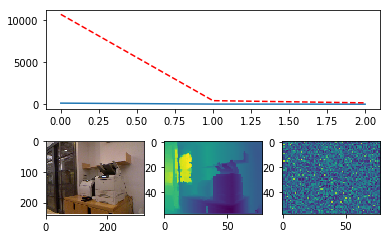

Epoch 3.
Loss: 7.191855430603027.
Completed in 158.543909s
Best loss achieved. Saving model to model-reshaped:0


Epoch 4...
128 / 2501 [6.918528s]
256 / 2501 [6.274924s]
384 / 2501 [6.218964s]
512 / 2501 [6.36267s]
640 / 2501 [6.32809s]
768 / 2501 [6.1367s]
896 / 2501 [6.34166s]
1024 / 2501 [6.383006s]
1152 / 2501 [6.31236s]
1280 / 2501 [6.377544s]
1408 / 2501 [7.158401s]
1536 / 2501 [6.344674s]
1664 / 2501 [6.178384s]
1792 / 2501 [6.223025s]
1920 / 2501 [8.421585s]


KeyboardInterrupt: 

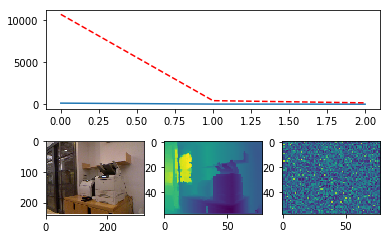

In [16]:
train(reshaped)

In [ ]:
reshaped = tf.stop_gradient(reshaped)
train(fine3, restore=True)

In [ ]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    
    gen = batch_generator(images, depths, batch_size=1)
    X, Y = next(gen)
    img = sess.run(tf.exp(reshaped), feed_dict={x: X, y: Y, keep_prob: 1.0})
    
    print(img.shape)
    
    fig = plt.figure()
    fig.set_figheight(50)
    fig.set_figwidth(50)
    sp = fig.add_subplot(1, 3, 1)
    sp.imshow(cv2.cvtColor(X[0], cv2.COLOR_YUV2BGR))
    sp = fig.add_subplot(1, 3, 2)
    sp.imshow(Y[0, :, :, 0], cmap='hot')
    sp = fig.add_subplot(1, 3, 3)
    sp.imshow(img[0, :, :, 0], cmap='hot')